In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-globalapprox-improper)=
# Improper integrals

```{index} improper integral
```

When the interval of integration or the integrand itself is unbounded, we say an integral is *improper*. Improper integrals present particular challenges to numerical computation.

## Infinite interval

When the integration domain is $(-\infty,\infty)$, the integrand has to decay as $x \to \pm \infty$ in order for the improper integral to be finite. This fact brings up the possibility of truncating the domain:

:::{math}
:label: infiniteinterval
\int_{-\infty}^{\infty} f(x)\, dx \approx  \int_{-M}^{M} f(x)\, dx.
:::

This integral can be discretized finitely by, say, the trapezoid formula, or an adaptive integrator. However, this approach can be inefficient.

(example-improper-slowdecay)=
::::{proof:example}
Consider the integral of $f(x)=1/(1+x^2)$,

$$
  \int_{-\infty}^\infty \frac{1}{1+x^{2}}\, dx = \pi.
$$

In this case we can easily estimate the effect of truncation on the result. For large $M$, 

$$
\int_M^\infty f\,dx \approx \int_M^\infty x^{-2}\,dx =  M^{-1}.
$$

The same estimate applies to the integral over $(-\infty,-M)$. To get eight digits of accuracy, for instance, we need to truncate with $M > 2 \times 10^8$. 
::::

## Double exponential transformation

In order to do better than direct truncation, we want to encourage the function to decay faster. In practice this means a change of variable, $x(t)$. If $|x(t)|$ grows rapidly as $|t| \to \infty$, then $f(x(t))$ will decay more rapidly in $t$ than in $x$. 

One way to accomplish this feat is to use

:::{math}
  :label: DEquadtrans1
  x(t) = \sinh\left(  \sinh t \right).
:::

Noting the asymptotic behavior as $t \rightarrow \pm\infty$ that

:::{math}
  :label: sinh-asymp
  \left| \sinh(t) \right| \sim \frac{1}{2} e^{ |t| },
:::

we find that in the same limits,

$$
x(t) \approx \pm \frac{1}{2} \exp\left( \frac{1}{2} e^{ |t| } \right).
$$

```{index} ! double exponential transformation
```
Thus, {eq}`DEquadtrans1` is often referred to as a **double exponential** transformation.

By the chain rule,

:::{math}
:label: DEquadchain1
\int_{-\infty}^\infty f(x)\, dx &= \int_{-\infty}^\infty f(x(t))\frac{dx}{dt}\, dt \\
  &= \int_{-\infty}^\infty f(x(t))\, \cosh\left( \sinh t \right)  \cosh t  \, dt.
:::

The exponential terms introduced by the chain rule grow double exponentially, but the more rapid decay of $f$ in the new variable more than makes up for this.

(demo-improper-decay)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Consider again $f(x)=1/(1+x^2)$ from {numref}`Example %s <example-improper-slowdecay>`, with $x(t)$ given by {eq}`DEquadtrans1`. As $t\to\infty$, 

$$
f(x(t)) \approx x^{-2} \approx 4 \exp\left( -e^{t} \right).
$$

The chain rule terms in {eq}`DEquadchain1` become

$$
\cosh\left( \sinh t \right)  \cosh t 
\approx \frac{1}{2} \exp\left( \frac{1}{2} e^t  \right)  \cdot \frac{1}{2} e^t,
$$ 

yielding a product that is roughly

$$
2 \exp\left( -\frac{1}{2} e^t  \right).
$$

The total integrand in {eq}`DEquadchain1` therefore has double exponential decay in $t$, essentially because of the squaring of $x$ in the denominator of $f$. The same result holds as $t\to-\infty$.

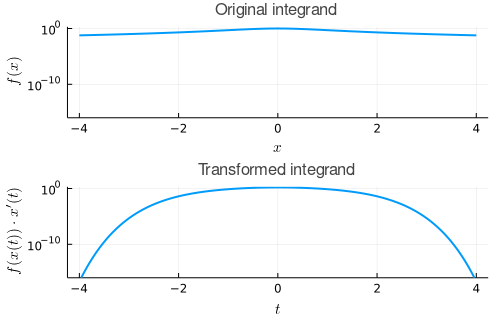

In [2]:
f = x -> 1/(1+x^2)
plot(f,-4,4,layout=(2,1),
    xlabel=L"x",yaxis=(:log10,L"f(x)",(1e-16,2)),
    title="Original integrand")

x = t -> sinh(π*sinh(t)/2)
dx_dt = t -> pi/2*cosh(t)*cosh(pi*sinh(t)/2)
g = t -> f(x(t))*dx_dt(t)

plot!(g,-4,4,subplot=2,
    xlabel=L"t",yaxis=(:log10,L"f(x(t))\cdot x'(t)",(1e-16,2)),
    title="Transformed integrand")

This graph suggests that we capture all of the integrand values that are larger than machine epsilon by integrating in $t$ from $-4$ to $4$.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

{numref}`Function {number} <function-intinf>` implements double exponential integration by applying the adaptive integrator {numref}`Function {number} <function-intadapt>` to {eq}`DEquadchain1`. It truncates the interval to $-M\le t \le M$ by increasing $M$ until the integrand is too small to matter relative to the error tolerance.

(function-intinf)=
````{proof:function} intinf
**Integration of a function over $(-\infty,\infty)$**
```{code-block} julia1
:lineno-start: 1
"""
    intinf(f,tol)

Perform adaptive doubly-exponential integration of function `f` 
over (-Inf,Inf), with error tolerance `tol`. Returns the integral 
estimate and a vector of the nodes used.
"""
function intinf(f,tol)   
    x = t -> sinh(sinh(t))
    dx_dt = t -> cosh(t)*cosh(sinh(t))
    g = t -> f(x(t))*dx_dt(t)

    # Find where to truncate the integration interval.
    M = 3
    while (abs(g(-M)) > tol/100) || (abs(g(M)) > tol/100)
        M += 0.5
        if isinf(x(M)) 
            @warn "Function may not decay fast enough."
            M -= 0.5
            break
        end
    end

    I,t = intadapt(g,-M,M,tol)
	return I,x.(t)
end
```
````

::::{admonition} About the code
:class: dropdown
The test `isinf(x(M))` in line 17 checks whether $x(M)$ is larger than the maximum double-precision value, causing it to *overflow* to `Inf`.
::::

(demo-improper-intinf)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We compare direct truncation in $x$ to the double exponential method of {numref}`Function {number} <function-intinf>` for $f(x)=1/(1+x^2)$.

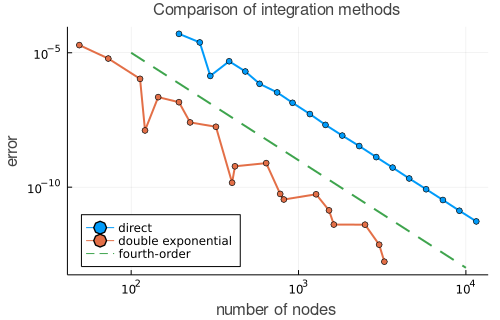

In [3]:
f = x -> 1/(1+x^2)
tol = [1/10^d for d in 5:0.5:14]
err = zeros(length(tol),2)
len = zeros(Int,length(tol),2)
for (i,tol) in enumerate(tol)
    I1,x1 = FNC.intadapt(f,-2/tol,2/tol,tol)
    I2,x2 = FNC.intinf(f,tol)
    @. err[i,:] = abs(π-[I1,I2])
    @. len[i,:] = length([x1,x2])
end
plot(len,err,m=:o,label=["direct" "double exponential"])
n = [100,10000]
plot!(n,1000n.^(-4),l=:dash,label="fourth-order",
     xaxis=(:log10,"number of nodes"),yaxis=(:log10,"error"),
     title="Comparison of integration methods",leg=:bottomleft)

Both methods are roughly fourth-order due to Simpson's formula in the underlying adaptive integration method. At equal numbers of evaluation nodes, however, the double exponential method is consistently 2--3 orders of magnitude more accurate.

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


## Integrand singularity

If $f$ asymptotically approaches infinity as $x$ approaches an integration endpoint, its exact integral may or may not be finite. If $f$ is integrable, then the part of the integration interval near the singularity needs to be more finely resolved than the rest of it. 

Let's consider 

:::{math}
:label: intsing
\int_0^1 f(x)\,dx,
:::

where $f$ and/or a derivative of $f$ is unbounded at the left endpoint, zero. The change of variable

:::{math}
  :label: DEquadtrans2
  x(t) = \frac{2}{1+\exp(2 \sinh t)}
:::

satisfies $x(0)=1$ and $x\to 0^+$ as $t\to \infty$, thereby transforming the integration interval to $t\in(0,\infty)$ and placing the singularity at infinity. The chain rule implies

:::{math}
  :label: DEquadchain2
  \int_{0}^1 f(x)\, dx &= \int_{0}^\infty f(x(t)) \frac{dx}{dt}\, dt \\
  &= \int_{0}^\infty f(x(t)) \frac{\cosh t}{\cosh(\sinh t)^2}  \,  dt.
:::

Now the growth of $f$ and $\cosh t$ together are counteracted by the double exponential denominator, allowing easy truncation of {eq}`DEquadchain2`. This variable transformation is paired with adaptive integration in {numref}`Function {number} <function-intsing>`.

(function-intsing)=
````{proof:function} intsing
**Integration of a function with endpoint singularities**
```{code-block} julia1
:lineno-start: 1
"""
    intsing(f,tol)

Adaptively integrate function `f` over (0,1), where `f` may be 
singular at zero, with error tolerance `tol`. Returns the
integral estimate and a vector of the nodes used.
"""
function intsing(f,tol)
    x = t -> 2/(1+exp(2sinh(t)))
	dx_dt = t -> cosh(t)/cosh(sinh(t))^2
	g = t -> f(x(t))*dx_dt(t)

    # Find where to truncate the integration interval.
    M = 3
    while abs(g(M)) > tol/100
        M += 0.5
        if iszero(x(M)) 
            @warn "Function may grow too rapidly."
            M -= 0.5
            break
        end
    end

    I,t = intadapt(g,0,M,tol)
	return I,x.(t)
end
```
````
::::{admonition} About the code
:class: dropdown
The test `iszero(x(M))` in line 17 checks whether $x(M)$ is less than the smallest positive double-precision value, causing it to *underflow* to zero.
::::

(demo-improper-intsing)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Let's use {numref}`Function {number} <function-intsing>` to compute

$$
\int_0^{0.01} \frac{1}{\sqrt{x}}\, dx.
$$

Since the integration interval is not $[0,1]$, we must first use the change of variable $s=100t$, yielding

$$
\int_0^{1} \frac{1}{10\sqrt{s}}\, ds = 0.2.
$$

In order to use {numref}`Function {number} <function-intadapt>`, we must truncate on the left to avoid evaluation at zero, where $f$ is infinite. Since the integral from $0$ to $\delta$ is $20\sqrt{\delta}$, we use $\delta=(\epsilon/20)^2$ to achieve error tolerance $\epsilon$.

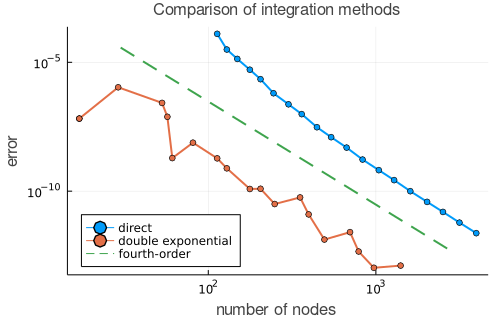

In [4]:
f = x -> 1/(10*sqrt(x))
tol = [1/10^d for d in 5:0.5:14]
err = zeros(length(tol),2)
len = zeros(Int,length(tol),2)
for (i,tol) in enumerate(tol)
    I1,x1 = FNC.intadapt(f,(tol/20)^2,1,tol)
    I2,x2 = FNC.intsing(f,tol)
    @. err[i,:] = abs(0.2-[I1,I2])
    @. len[i,:] = length([x1,x2])
end
plot(len,err,m=:o,label=["direct" "double exponential"])
n = [30,3000]
plot!(n,30n.^(-4),l=:dash,label="fourth-order",
     xaxis=(:log10,"number of nodes"),yaxis=(:log10,"error"),
     title="Comparison of integration methods",leg=:bottomleft)

As in {numref}`Demo {number} <demo-improper-intinf>`, the double exponential method is more accurate than direct integration by a few orders of magnitude. Equivalently, the same accuracy can be reached with many fewer nodes.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

Double exponential integration is an effective general-purpose technique for improper integrals that usually outperforms interval truncation in the original variable. There are specialized methods tailored to specific singularity types that can best it, but those require more analytical work to use properly.

## Exercises

1. ⌨ Use {numref}`Function {number} <function-intinf>` to estimate the given integral with error tolerances $10^{-3},10^{-6},10^{-9},10^{-12}$. For each result, show the actual error and the number of nodes used.

    **(a)** $\displaystyle\int_{-\infty}^\infty \dfrac{1}{1+x^2+x^4}\, dx = \dfrac{\pi}{\sqrt{3}}$
  
    **(b)** $\displaystyle\int_{-\infty}^\infty e^{-x^2}\cos(x)\, dx = e^{-1/4}\sqrt{\pi}$
  
    **(c)** $\displaystyle\int_{-\infty}^\infty (1+x^2)^{-2/3}\, dx = \dfrac{\sqrt{\pi}\,\Gamma(1/6)}{\Gamma(2/3)}$  (use `gamma()` for $\Gamma()$)


2. ⌨ Use {numref}`Function {number} <function-intsing>` to estimate the given integral, possibly after rewriting the integral into the form {eq}`intsing` with a left-endpoint singularity. Use error tolerances $10^{-3},10^{-6},10^{-9},10^{-12}$, and for each result, show the actual error and the number of nodes used.

    **(a)** $\displaystyle\int_{0}^1 (\log x)^2\, dx = 2$
  
    **(b)** $\displaystyle\int_{0}^{\pi/4} \sqrt{\tan(x)}\, dx = \dfrac{\pi}{\sqrt{2}}$

    **(c)** $\displaystyle\int_{0}^1 \frac{1}{\sqrt{1-x^2}}\, dx = \dfrac{\pi}{2}$
 
3. For integration on a semi-infinite interval such as $x\in [0,\infty)$, another double exponential transformation is useful: $x(t)=\exp\left( \sinh t \right)$.

    **(a)** ✍ Show that $t\in(-\infty,\infty)$ is mapped to $x\in (0,\infty)$. 
    
    **(b)** ✍ Derive an analog of {eq}`DEquadchain1` for the chain rule on $\int_0^\infty f(x)\,dx$. 
    
    **(c)** ✍ Show that truncation of $t$ to $[-M,M]$ will truncate $x$ to $[1/\mu,\mu]$ for some positive $\mu$. 
   
    **(d)** ⌨ Write a function `intsemi(f,tol)` for the semi-infinite integration problem. Test it on the integral
    
    $$  
      \displaystyle\int_0^\infty \frac{e^{-x}}{\sqrt{x}}\,dx = \sqrt{\pi}.
    $$